In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np

Let's see if we can get Aaron's delay network to recognize two different patterns.  First, let's create the patterns.  For this simple test, we'll just use a 1Hz sine wave and a 0.5Hz sine wave for the two patterns.

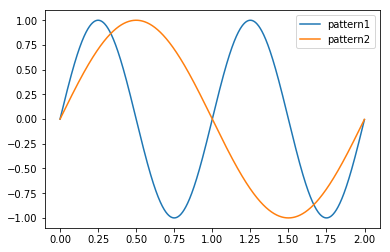

In [2]:
s_pattern = 2000                # number of data points in the pattern
t = np.arange(s_pattern)*0.001  # time points for the elements in the patter

pattern1 = np.sin(t*np.pi*2)
pattern2 = np.sin(0.5*t*np.pi*2)

plt.plot(t, pattern1, label='pattern1')
plt.plot(t, pattern2, label='pattern2')
plt.legend(loc='best')
plt.show()

Now let's create a network that represents a rolling window in time (Aaron's "delay network").  The `process` determines what sort of pattern the network will be optimized for -- here we just go with white noise of a maximum of 3Hz.  `theta` determines how big the rolling window is -- here we use 0.5 seconds.

In [3]:
net = nengo.Network()
with net:
    process = nengo.processes.WhiteSignal(period=100., high=3., y0=0)
    rw = nengolib.networks.RollingWindow(theta=0.5, n_neurons=3000, process=process, neuron_type=nengo.LIFRate())

c:\users\terry\py3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


Now we need to create the training data for decoding out of the rolling window.  Our patterns are larger than the rolling window, so to create our training data we will take our patterns, shift them, and cut them down to the right size.  In order to then give that to nengo, we also need to project from the window's space to the internal representation space (using the `inv_basis`).

The `target` array is the desired output value for each of the slices of the pattern in `eval_points`.  We'll use 1 for pattern1 and -1 for pattern2.

In [4]:
s_window = 500

t_window = np.linspace(0, 1, s_window)
inv_basis = rw.inverse_basis(t_window)
    
eval_points = []
target = []
for i in range(s_pattern):
    eval_points.append(np.dot(inv_basis, np.roll(pattern1, i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(pattern2, i)[:s_window]))
    target.append([-1])

Now we can create a connection optimized to do this decoding

In [5]:
with net:
    result = nengo.Node(None, size_in=1)
    nengo.Connection(rw.state, result,
                     eval_points=eval_points, scale_eval_points=False,
                     function=target, synapse=0.1)

Let's try feeding in those two patterns and see what the response is

c:\users\terry\documents\github\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

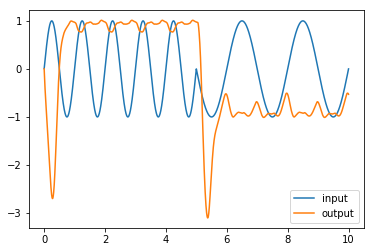

In [6]:
model = nengo.Network()
model.networks.append(net)
with model:
    freqs = [1, 0.5]
    def stim_func(t):
        freq = freqs[int(t/5) % len(freqs)]
        return np.sin(t*2*np.pi*freq)
    
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, rw.input, synapse=None)
    
    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
sim = nengo.Simulator(model)
sim.run(10)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')

It successfully detects the two frequencies, outputting 1 for the 1Hz pattern (pattern1) and -1 for the 0.5Hz (pattern2)!

Note that it has never observed a transition between frequencies, so it's somewhat reasonable that it's confused at the transitions.  This could be fixed by adding more training data that includes such transitions.


Now let's try intermediate frequencies that it has never seen before:

c:\users\terry\documents\github\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

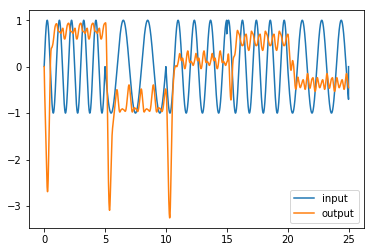

In [7]:
model = nengo.Network()
model.networks.append(net)
with model:
    freqs = [1, 0.5, 0.75, 0.875, 0.625]
    def stim_func(t):
        freq = freqs[int(t/5) % len(freqs)]
        return np.sin(t*2*np.pi*freq)
    
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, rw.input, synapse=None)
    
    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
sim = nengo.Simulator(model)
sim.run(25)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')

The network successfully interpolates between the two patterns it was trained on!